In [ ]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [ ]:
# Load Necessary Libraries

import os
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt

import h2o
from h2o.automl import H2OAutoML
from sklearn.metrics import mean_squared_error

seed = 5

# Load and Prepare Saved Data

In [ ]:
# Get parent directory (One level up)
path_parent = os.path.dirname(os.getcwd())
# Join path name as parent directory and file name
path_file_train = os.path.join(path_parent, 'accident_train.csv')
path_file_test = os.path.join(path_parent, 'accident_test.csv')

In [ ]:
## Load preprocessed file

Xy_train = pd.read_csv(path_file_train, sep = ',')
Xy_test = pd.read_csv(path_file_test, sep = ',')

### Prepare Data for Modelling

We will model our data such that we will first predict 'Number_of_Casualties' by using H2O classification methods (Columns 'Accident_ID'and 'postcode' removed during training) and after training, calcualte 'Accident Risk Index' using the calculated predicted values, 'Accident Id' and 'postcode'.

Note: We can also model for 'Accident Risk Index' and predict its value directly. However, for that that data needs to be stratified split across 'postcode' as well and all 'postcode' type which contain a unit/single data point/value need to be either upsampled or manually added to training data set (Stratified Split won't work for datasets with unit value counts/frequency)

In [ ]:
def prepare_model_data(data, output_col, remove_col):
  X = data.drop(columns = output_col + remove_col)
  y = data['Number_of_Casualties']
  y = y.values.ravel()
  return X, y

In [ ]:
X_train, y_train = prepare_model_data(Xy_train, ['Number_of_Casualties'], 
                                      ['Accident_ID', 'postcode'])
X_test, y_test = prepare_model_data(Xy_test, ['Number_of_Casualties'], 
                                      ['Accident_ID', 'postcode'])

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(335118, 23) (335118,)
(143623, 23) (143623,)


We will next define a function to prepare the data so as to calculate 'Accident Risk Index'

In [ ]:
def cal_ari(data):
  # we need to calculate Accident_Risk_Index as sum(Number_of_casualities)/count(Accident_ID)
  grouped_train = data.groupby('postcode') # group by postcode
  
  #create aggregation functions
  aggregations = {'Number_of_Casualties': [np.mean],
                  'Accident_ID': [np.count_nonzero]}
  aggregated_ = grouped_train.agg(aggregations)
  
  # formula mentioned above is used to calculate <Accident_Risk_Index>
  aggregated_['Accident_risk_index'] = aggregated_['Number_of_Casualties']['mean']/aggregated_['Accident_ID']['count_nonzero']
  return aggregated_

Preparing Test Data with 'Accident Risk Index'

In [ ]:
ari_test = cal_ari(Xy_test)

# Metric

We will use mean squared error metric to measure performance of our models

## Preparing data for H2O 

In [ ]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 25 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_unknownUser_ldj45h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.552 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Covert data to H2O frame

In [ ]:
xy_train = h2o.H2OFrame(Xy_train)
xy_test = h2o.H2OFrame(Xy_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Identify predictors and response
remove_cols = ['Accident_ID', 'Number_of_Casualties', 'postcode']
x_col = list(set(xy_train.columns) - set(remove_cols))
y_col = "Number_of_Casualties"

# Training

As our classes are unbalanced, we will make use of the parameter 'balance_classes'

In [ ]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_models = 10, balance_classes = True, seed = seed)
aml.train(x = x_col, y = y_col, training_frame = xy_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_2_20220426_100654


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,48925.0,7.0,7.0,7.0,66.0,126.0,106.74286




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.6505900494524749
RMSE: 0.8065916249580545
MAE: 0.6260620972860752
RMSLE: 0.2706901056972048
Mean Residual Deviance: 0.6505900494524749

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.6566956086390211
RMSE: 0.8103675762510621
MAE: 0.6288267680101227
RMSLE: 0.27214239066487667
Mean Residual Deviance: 0.6566956086390211

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.628827,0.001856,0.629922,0.629904,0.628400,0.625750,0.630158
1,mean_residual_deviance,0.656696,0.007298,0.662820,0.659873,0.653280,0.645493,0.662011
2,mse,0.656696,0.007298,0.662820,0.659873,0.653280,0.645493,0.662011
3,r2,0.013789,0.000260,0.013647,0.014185,0.013872,0.013742,0.013500
4,residual_deviance,0.656696,0.007298,0.662820,0.659873,0.653280,0.645493,0.662011
5,rmse,0.810357,0.004511,0.814138,0.812326,0.808257,0.803426,0.813641
6,rmsle,0.272141,0.000845,0.272733,0.272501,0.271819,0.270808,0.272846



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-04-26 10:31:27,1 min 32.398 sec,0.0,0.816017,0.637332,0.665884
1,,2022-04-26 10:31:29,1 min 34.972 sec,5.0,0.811917,0.633441,0.659209
2,,2022-04-26 10:31:32,1 min 37.468 sec,10.0,0.810078,0.631099,0.656226
3,,2022-04-26 10:31:34,1 min 39.976 sec,15.0,0.809074,0.629399,0.654600
4,,2022-04-26 10:31:37,1 min 42.487 sec,20.0,0.808309,0.628175,0.653363
5,,2022-04-26 10:31:39,1 min 45.017 sec,25.0,0.807683,0.627394,0.652352
6,,2022-04-26 10:31:42,1 min 47.504 sec,30.0,0.807090,0.626634,0.651394
7,,2022-04-26 10:31:44,1 min 49.994 sec,35.0,0.806592,0.626062,0.650590



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Police_Force,10432.701172,1.000000,0.418088
1,1st_Road_Class_Number_of_Casualties,1837.653076,0.176144,0.073644
2,Number_of_Vehicles,1743.244873,0.167094,0.069860
3,Speed_limit,1523.726685,0.146053,0.061063
4,2nd_Road_Class_Number_of_Casualties,910.505798,0.087274,0.036488
5,Month_Cos,788.746887,0.075603,0.031609
6,Urban_or_Rural_Area,754.828369,0.072352,0.030250
7,Month_Sin,743.418640,0.071259,0.029792
8,Day_of_Week_Sin,688.376038,0.065983,0.027587
9,Weather_Conditions_Number_of_Casualties,614.342041,0.058886,0.024620



See the whole table with table.as_data_frame()


In [ ]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows = lb.nrows)  # Print all rows instead of default (10 rows)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_2_AutoML_2_20220426_100654,0.810368,0.656696,0.628827,0.272142,0.656696
StackedEnsemble_AllModels_1_AutoML_2_20220426_100654,0.810399,0.656746,0.629874,0.272055,0.656746
StackedEnsemble_BestOfFamily_1_AutoML_2_20220426_100654,0.81045,0.656828,0.630063,0.272061,0.656828
GBM_3_AutoML_2_20220426_100654,0.810577,0.657036,0.629506,0.272197,0.657036
XGBoost_3_AutoML_2_20220426_100654,0.810762,0.657335,0.628206,0.272359,0.657335
GBM_4_AutoML_2_20220426_100654,0.811281,0.658176,0.629206,0.272523,0.658176
GBM_1_AutoML_2_20220426_100654,0.811516,0.658558,0.629588,0.27259,0.658558
GLM_1_AutoML_2_20220426_100654,0.813469,0.661732,0.633261,0.273149,0.661732
XRT_1_AutoML_2_20220426_100654,0.816317,0.666374,0.633572,0.275518,0.666374
DRF_1_AutoML_2_20220426_100654,0.819346,0.671327,0.633774,0.276949,0.671327


## Training Plots

### Variable importance heatmap

It shows variable importance across multiple models.

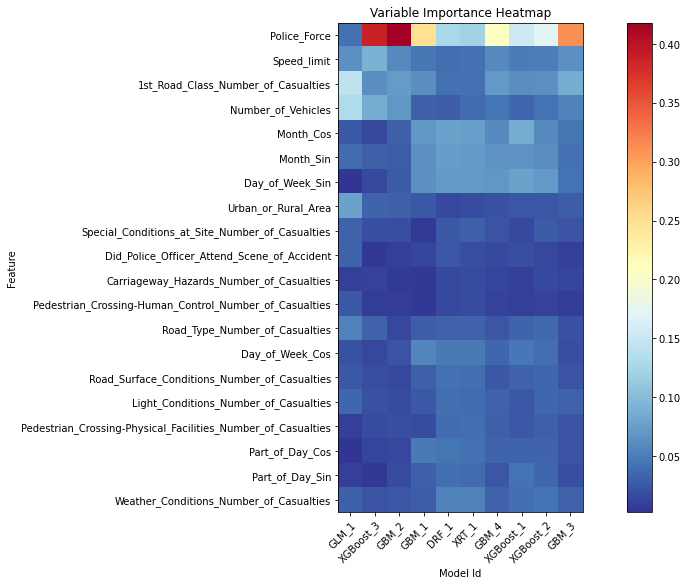

In [ ]:
h2o.varimp_heatmap(aml)
plt.show()

# Evaluation

Evaluating model with best 'mean squared error' for 'Number of Casualties'

In [ ]:
m = aml.get_best_model(criterion = "MSE")
m

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_2_20220426_100654


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,48925.0,7.0,7.0,7.0,66.0,126.0,106.74286




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.6505900494524749
RMSE: 0.8065916249580545
MAE: 0.6260620972860752
RMSLE: 0.2706901056972048
Mean Residual Deviance: 0.6505900494524749

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.6566956086390211
RMSE: 0.8103675762510621
MAE: 0.6288267680101227
RMSLE: 0.27214239066487667
Mean Residual Deviance: 0.6566956086390211

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.628827,0.001856,0.629922,0.629904,0.628400,0.625750,0.630158
1,mean_residual_deviance,0.656696,0.007298,0.662820,0.659873,0.653280,0.645493,0.662011
2,mse,0.656696,0.007298,0.662820,0.659873,0.653280,0.645493,0.662011
3,r2,0.013789,0.000260,0.013647,0.014185,0.013872,0.013742,0.013500
4,residual_deviance,0.656696,0.007298,0.662820,0.659873,0.653280,0.645493,0.662011
5,rmse,0.810357,0.004511,0.814138,0.812326,0.808257,0.803426,0.813641
6,rmsle,0.272141,0.000845,0.272733,0.272501,0.271819,0.270808,0.272846



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2022-04-26 10:31:27,1 min 32.398 sec,0.0,0.816017,0.637332,0.665884
1,,2022-04-26 10:31:29,1 min 34.972 sec,5.0,0.811917,0.633441,0.659209
2,,2022-04-26 10:31:32,1 min 37.468 sec,10.0,0.810078,0.631099,0.656226
3,,2022-04-26 10:31:34,1 min 39.976 sec,15.0,0.809074,0.629399,0.654600
4,,2022-04-26 10:31:37,1 min 42.487 sec,20.0,0.808309,0.628175,0.653363
5,,2022-04-26 10:31:39,1 min 45.017 sec,25.0,0.807683,0.627394,0.652352
6,,2022-04-26 10:31:42,1 min 47.504 sec,30.0,0.807090,0.626634,0.651394
7,,2022-04-26 10:31:44,1 min 49.994 sec,35.0,0.806592,0.626062,0.650590



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Police_Force,10432.701172,1.000000,0.418088
1,1st_Road_Class_Number_of_Casualties,1837.653076,0.176144,0.073644
2,Number_of_Vehicles,1743.244873,0.167094,0.069860
3,Speed_limit,1523.726685,0.146053,0.061063
4,2nd_Road_Class_Number_of_Casualties,910.505798,0.087274,0.036488
5,Month_Cos,788.746887,0.075603,0.031609
6,Urban_or_Rural_Area,754.828369,0.072352,0.030250
7,Month_Sin,743.418640,0.071259,0.029792
8,Day_of_Week_Sin,688.376038,0.065983,0.027587
9,Weather_Conditions_Number_of_Casualties,614.342041,0.058886,0.024620



See the whole table with table.as_data_frame()


### Learning Curve Plot

Learning curves show error metric dependence on learning progress, 
Here it shows, MSE vs number of trees trained so far in GBM_2

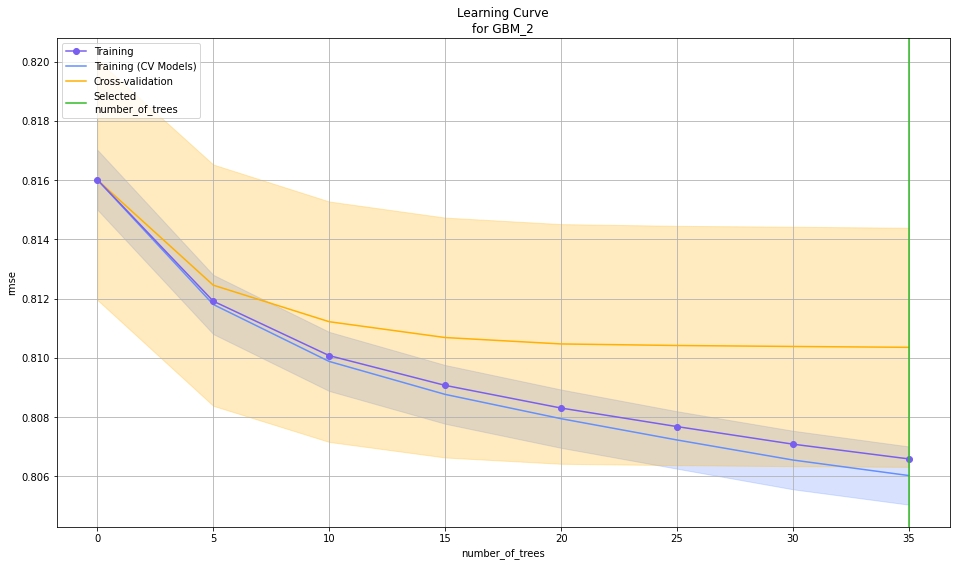

In [ ]:
learning_curve_plot = m.learning_curve_plot()

## Predicting test values using best model

In [ ]:
preds = aml.leader.predict(xy_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [ ]:
xy_test['Number_of_Casualties'] = preds

Best Model Performace for 'Number of Casualties'

In [ ]:
perf = aml.leader.model_performance(xy_test)
perf


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 1.190789915216667e-15
RMSE: 3.4507823971045566e-08
MAE: 2.991948247087409e-08
RMSLE: 1.4034757883119682e-08
Mean Residual Deviance: 1.190789915216667e-15


In [ ]:
# Converting to pandas dataframe from H2O dataframe
prediction = h2o.as_list(preds, use_pandas = True) 

Calculating Accident Risk Index for predicted values

In [ ]:
pred_test = copy.deepcopy(Xy_test)

pred_test['Number_of_Casualties'] = prediction.values

In [ ]:
ari_pred = cal_ari(pred_test)

Mean Squared Error for 'Accident Risk Index'

In [ ]:
print("Mean Squared Error: {}".format(mean_squared_error(ari_test['Accident_risk_index'], 
                                                         ari_pred['Accident_risk_index'],
                                                         squared = False)))

Mean Squared Error: 0.5464696601612201


## Evaluation Plots 

Plots with respect to target variable as 'Number of Casualties'

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

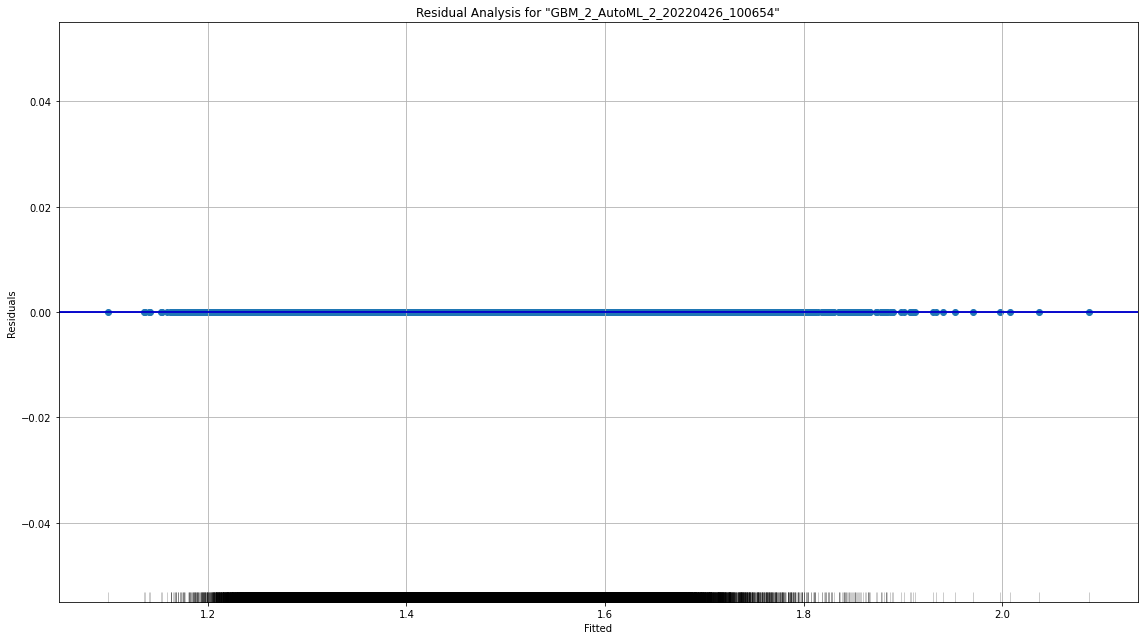

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

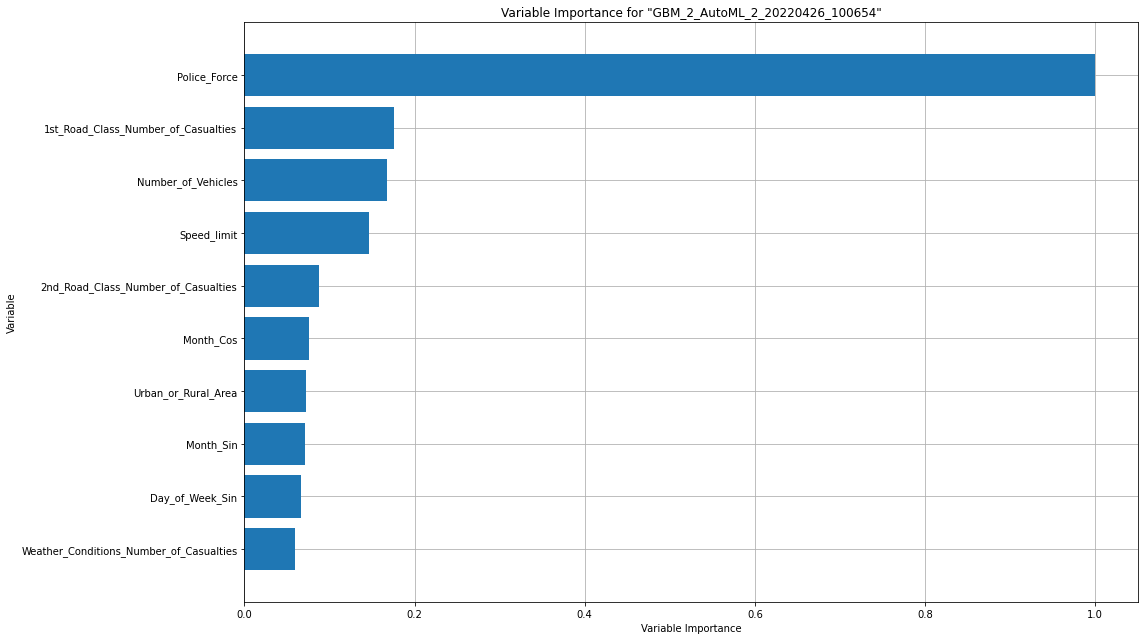

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

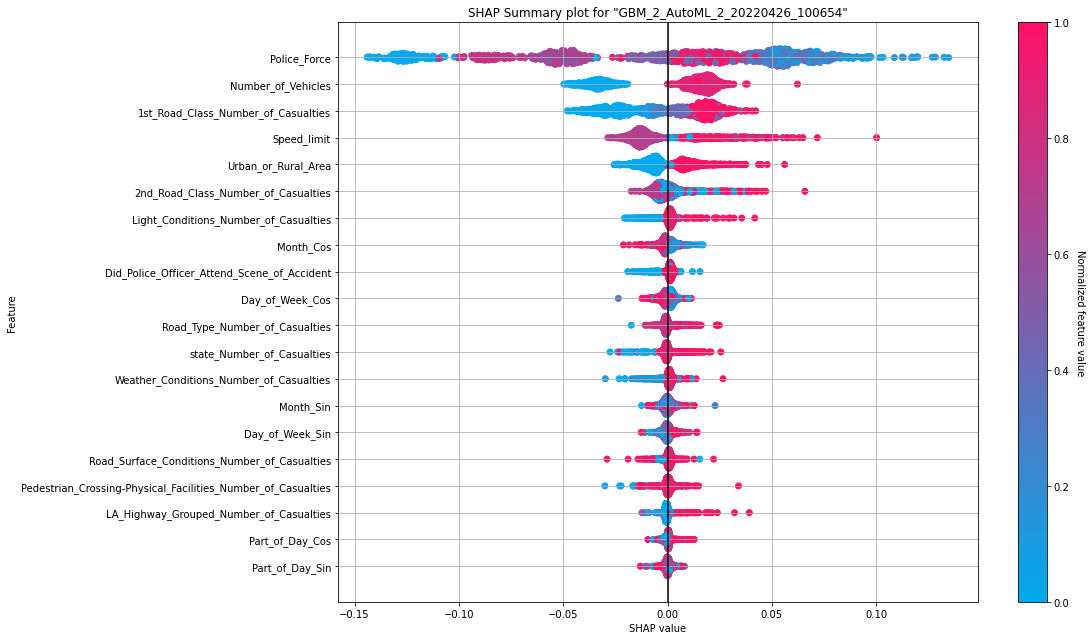

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

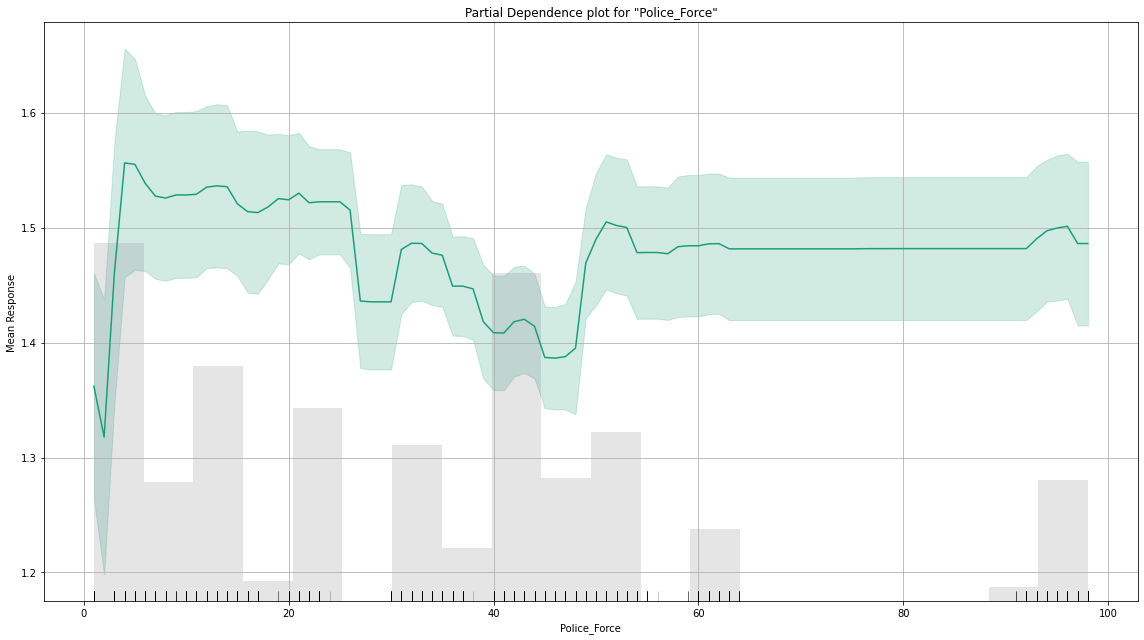

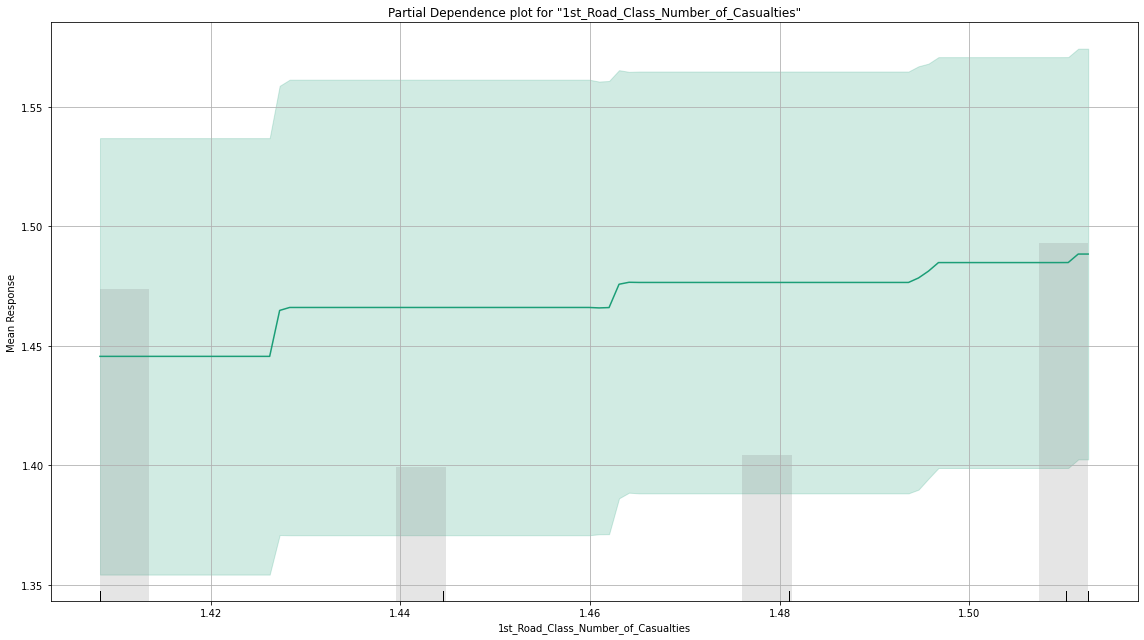

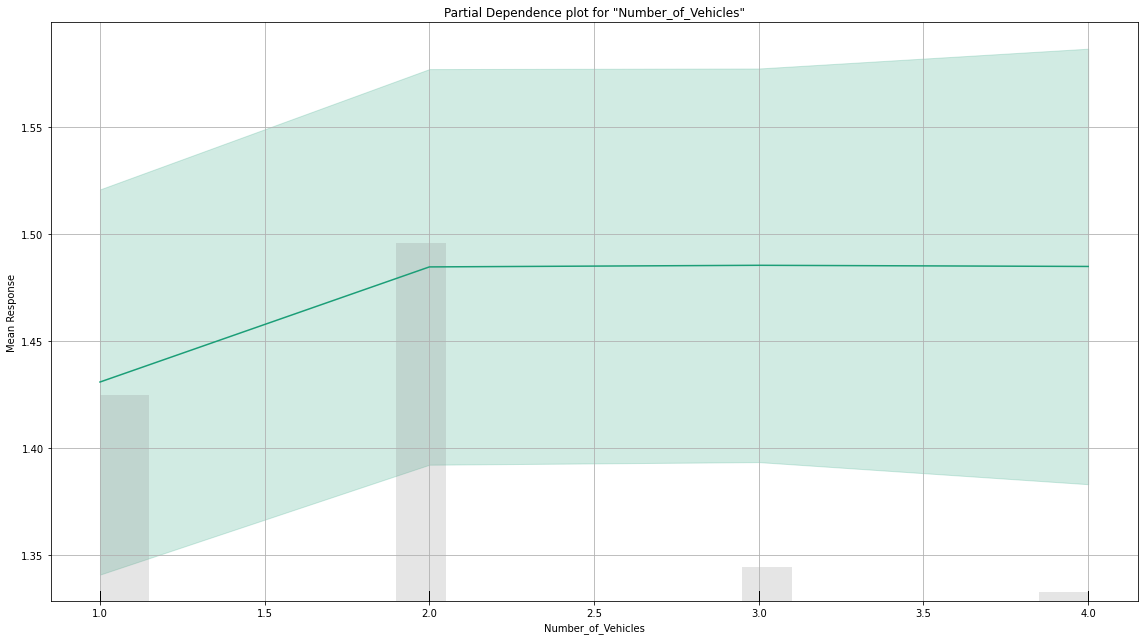

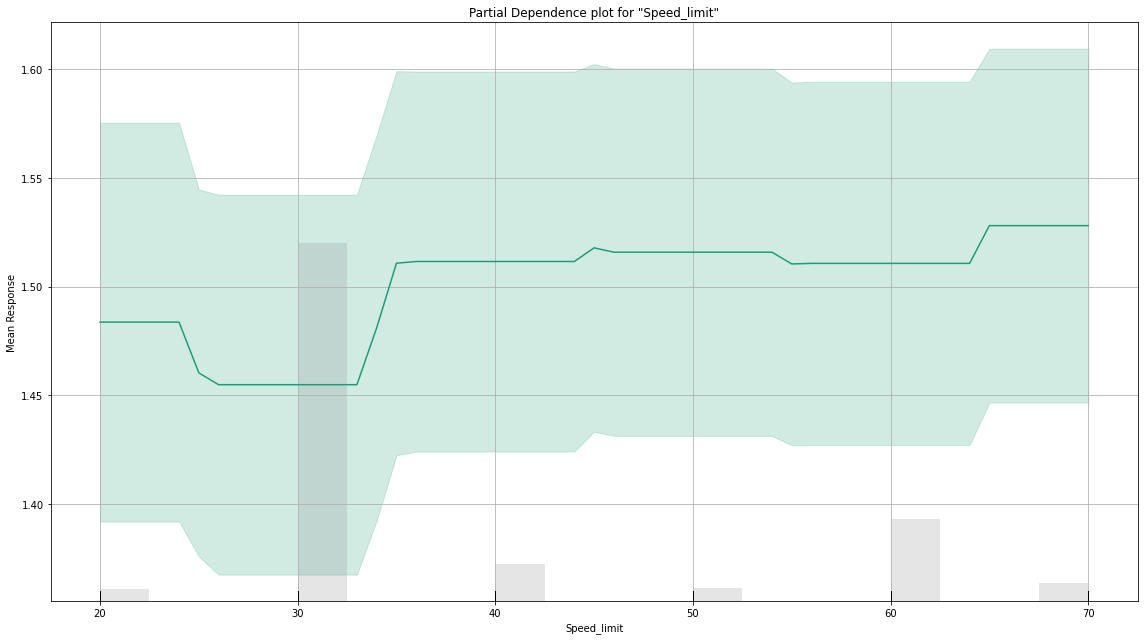

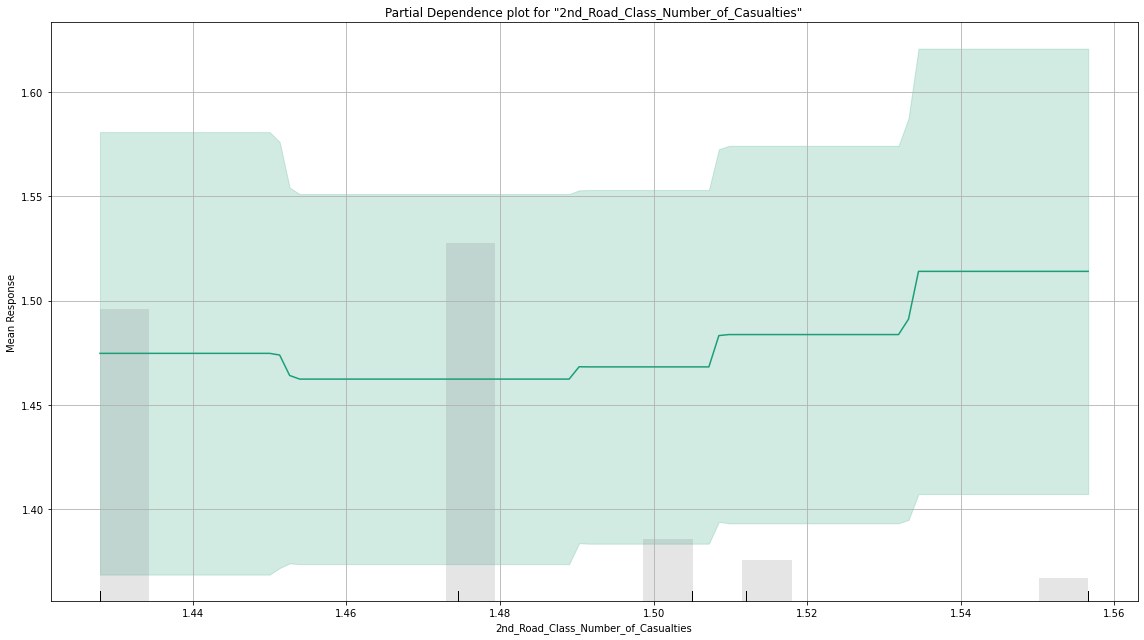

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

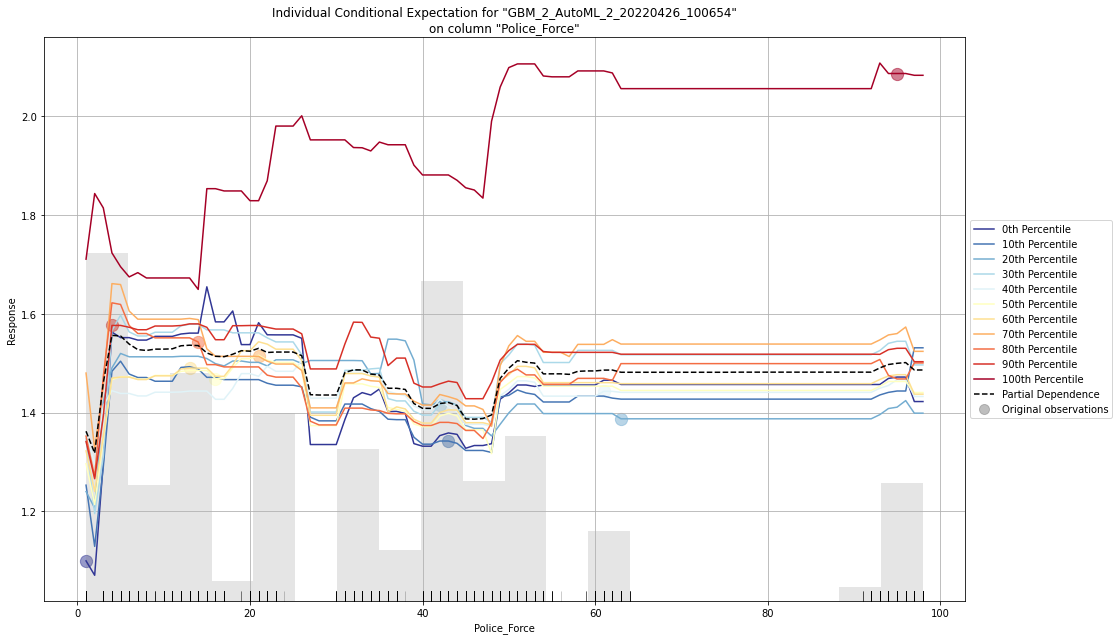

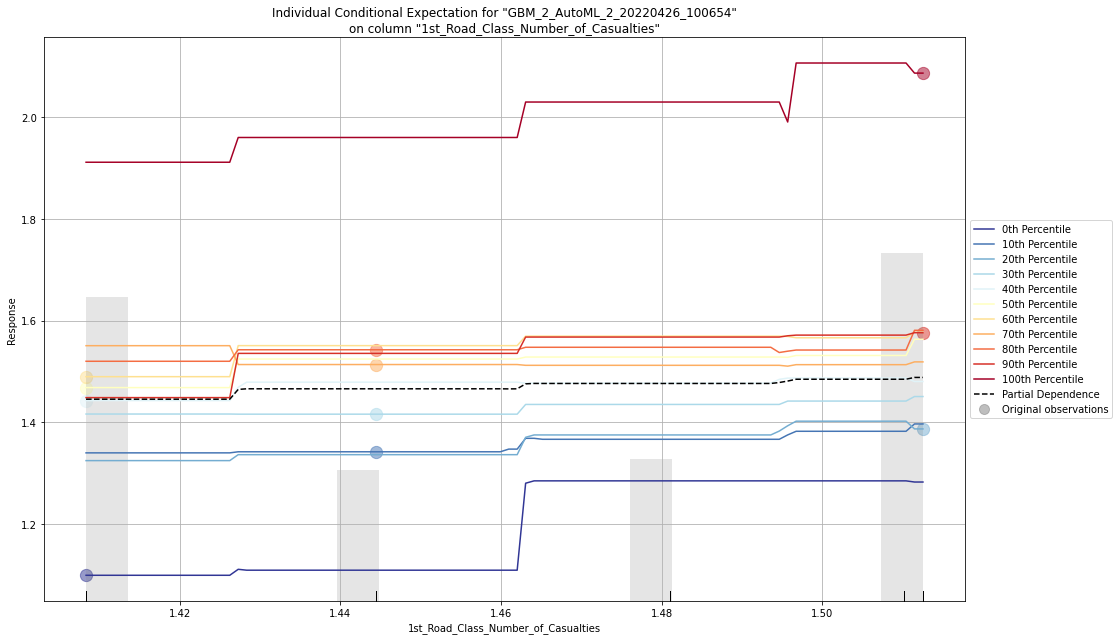

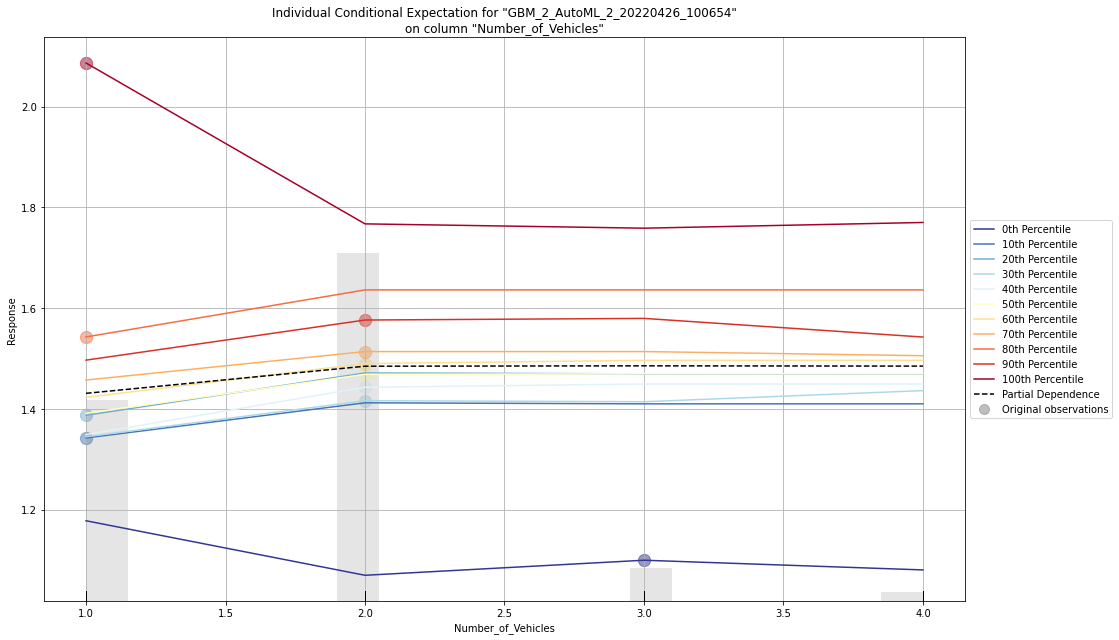

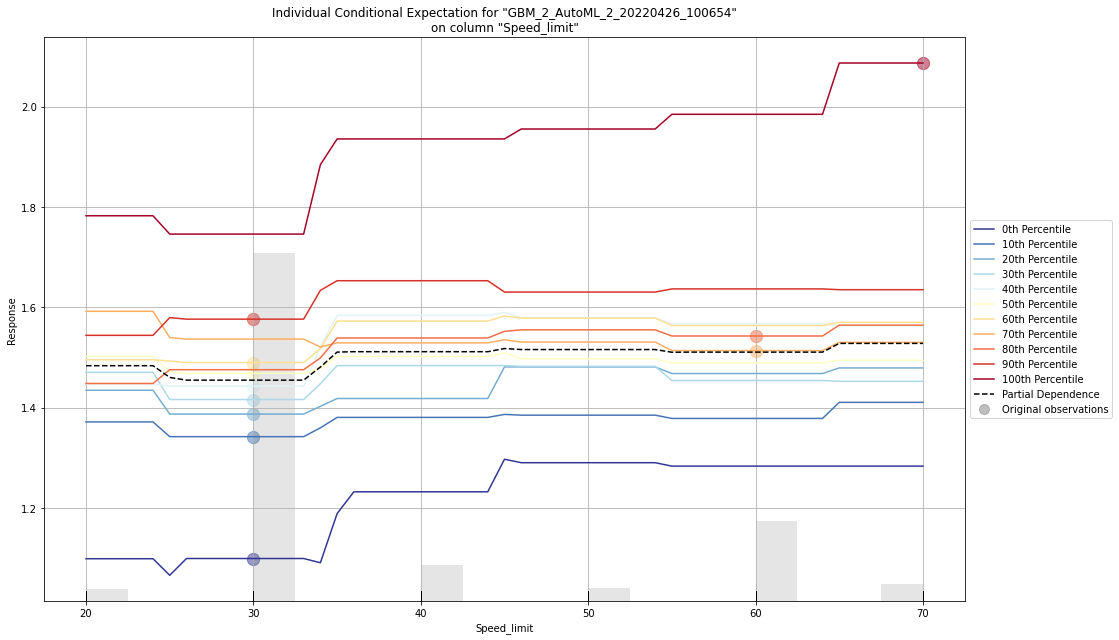

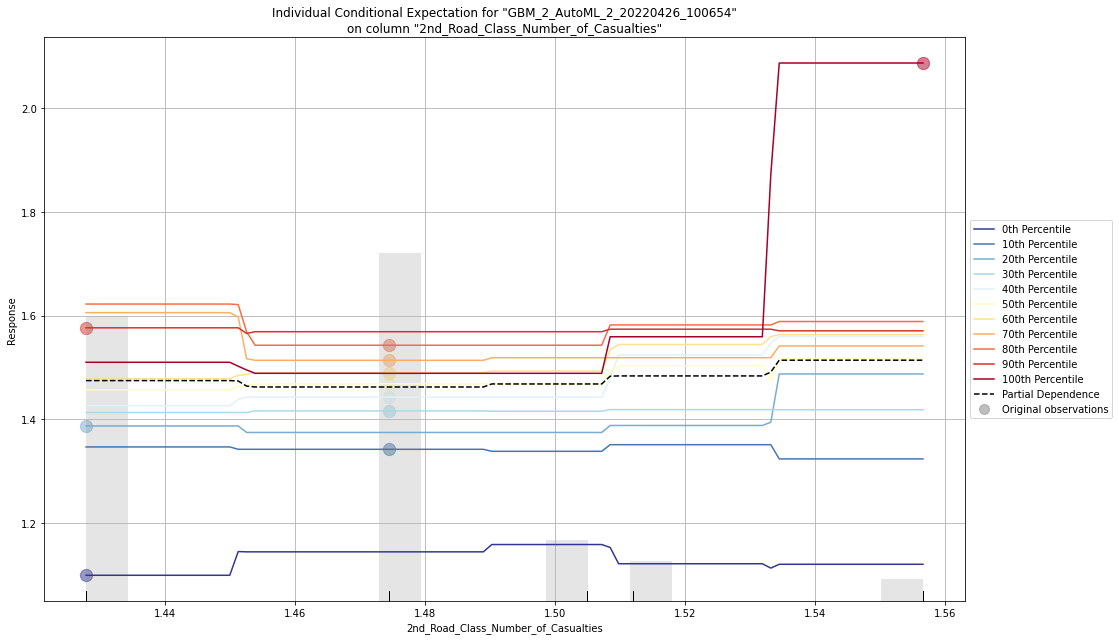

In [ ]:
# Explain a single H2O model (e.g. leader model from AutoML)
exm = aml.leader.explain(xy_test)

###  SHAP Local Explanation

SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function

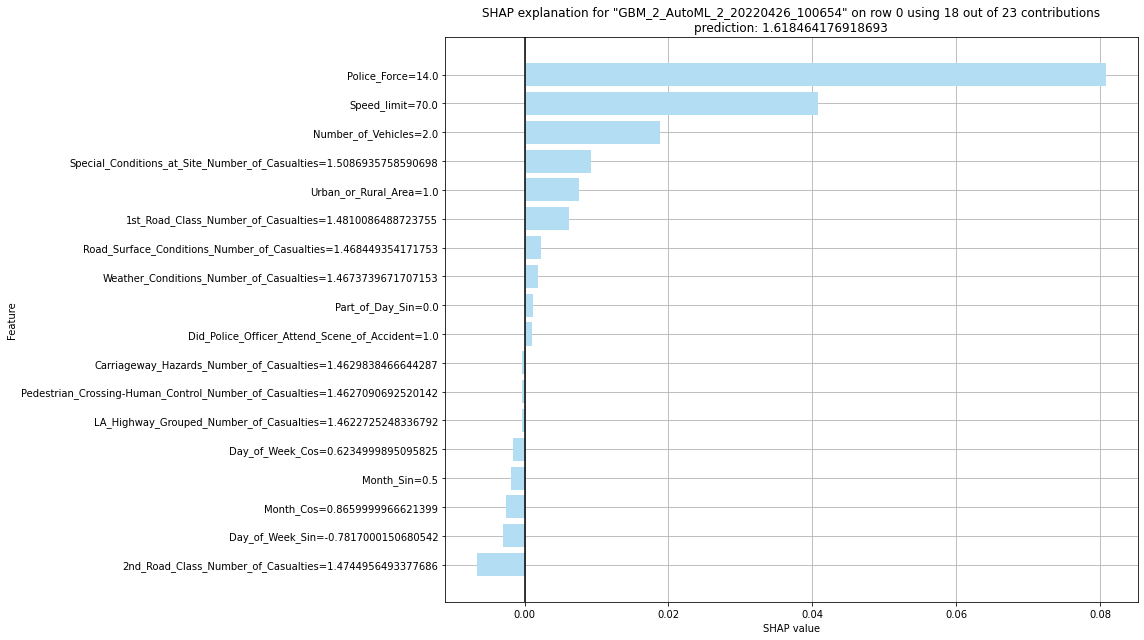

In [ ]:
shapr_plot = m.shap_explain_row_plot(xy_test, row_index = 0)

## Model Prediction Correlation Heatmap

This plot shows the correlation between the predictions of the models

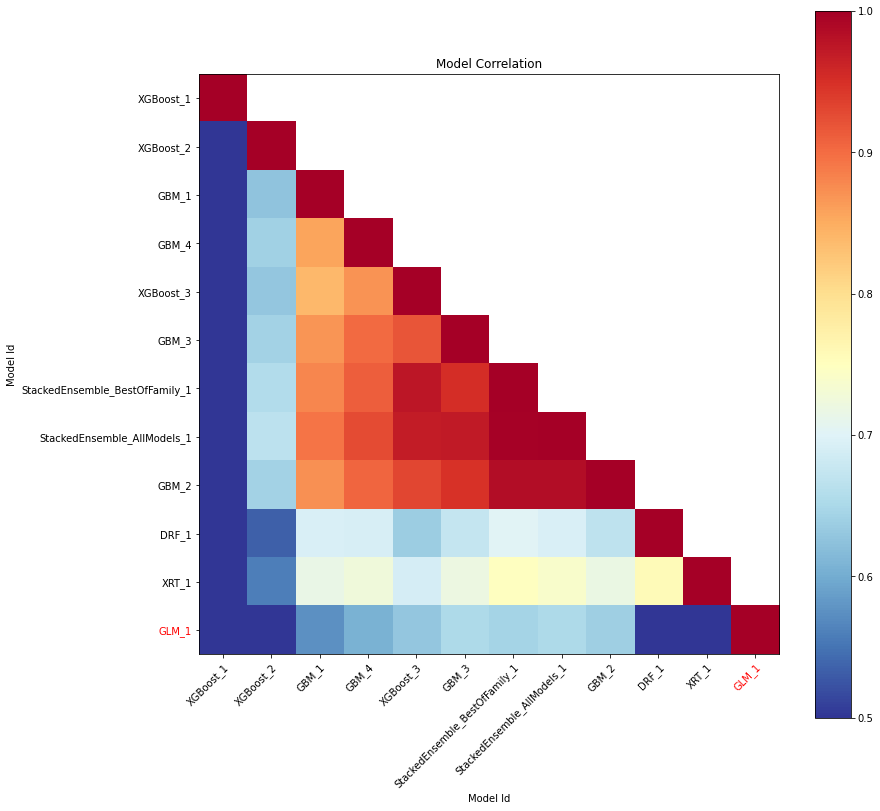

In [ ]:
h2o.model_correlation_heatmap(aml, xy_test)
plt.show()

## Other Miscellaneous Info

In [ ]:
# Get AutoML event log
log = aml.event_log
log

timestamp,level,stage,message,name,value
10:06:54.445,INFO,Workflow,Project: AutoML_2_20220426_100654,,
10:06:54.445,INFO,Validation,5-fold cross-validation will be used.,,
10:06:54.445,INFO,Validation,Setting stopping tolerance adaptively based on the training frame: 0.001727432643542916,,
10:06:54.445,INFO,Validation,Build control seed: 5,,
10:06:54.446,INFO,DataImport,training frame: Frame key: AutoML_2_20220426_100654_training_Key_Frame__upload_b2f2481c0822f83bc85d8bb9b8a3453f.hex cols: 26 rows: 335118 chunks: 24 size: 22581104 checksum: -7976194288156598948,,
10:06:54.446,INFO,DataImport,validation frame: NULL,,
10:06:54.446,INFO,DataImport,leaderboard frame: NULL,,
10:06:54.446,INFO,DataImport,blending frame: NULL,,
10:06:54.446,INFO,DataImport,response column: Number_of_Casualties,,
10:06:54.446,INFO,DataImport,fold column: null,,


In [ ]:
# Get training timing info
info = aml.training_info
info

{'creation_epoch': '1650967614',
 'duration_secs': '2619',
 'start_DRF_XRT': '1650969454',
 'start_DRF_def_1': '1650968275',
 'start_GBM_def_2': '1650968995',
 'start_GBM_def_3': '1650969105',
 'start_GBM_def_4': '1650969225',
 'start_GBM_def_5': '1650967917',
 'start_GLM_def_1': '1650967897',
 'start_StackedEnsemble_all_xglm': '1650970221',
 'start_StackedEnsemble_best_of_family_xglm': '1650970207',
 'start_XGBoost_def_1': '1650968103',
 'start_XGBoost_def_2': '1650967614',
 'start_XGBoost_def_3': '1650969373',
 'start_epoch': '1650967614',
 'stop_epoch': '1650970234'}